In [ ]:
import tensorflow

In [ ]:
import tensorflow.python.keras.engine

In [ ]:
pip install keras_vggface

In [ ]:
pip install keras_applications

In [ ]:
# check version of keras_vggface
import keras_vggface
import keras_applications

# print version
print(keras_vggface.__version__)

0.6


In [ ]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from zipfile import ZipFile

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = "/content/drive/MyDrive/105_classes_pins_dataset"

In [ ]:
import os
for filename in os.listdir(directory):
    os.rename(os.path.join(directory,filename),os.path.join(directory, filename.replace(' ', '_').upper()))
    st = "pins_"
    if st in filename:    
        filepath = os.path.join(directory, filename)
        newfilepath = os.path.join(directory, filename.replace(st, ""))
        os.rename(filepath, newfilepath)

for subdir, dirs, files in os.walk(directory):
    for file in files:
      os.rename(os.path.join(subdir, file), os.path.join(subdir, file.replace(' ', '_')))

In [ ]:
import glob

paths = glob.glob("C:/Users/Anirudh/Desktop/sample_project_1/105_classes_pins_dataset/*")
label_names = [os.path.split(x)[1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format((label_names)))

Total labels: 0
Labels: []


In [ ]:
df = pd.DataFrame(columns=['Person', 'No. of Images','File Path', 'Files'])

folders = [x[0] for x in os.walk(directory)]

for subfolders in folders:
  fileList = os.listdir(subfolders)
  filePath = os.path.abspath(subfolders)
  person = (subfolders)[len(directory)+1:]
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)

df

,Person,No. of Images,File Path,Files
0,,8,/content/drive/MyDrive/105_classes_pins_dataset,"[WENTWORTH_MILLER, CHRIS_EVANS, ZAC_EFRON, ZOE..."
1,WENTWORTH_MILLER,179,/content/drive/MyDrive/105_classes_pins_datase...,"[Wentworth_Miller83_169.jpg, Wentworth_Miller1..."
2,CHRIS_EVANS,166,/content/drive/MyDrive/105_classes_pins_datase...,"[Chris_Evans121_1127.jpg, Chris_Evans153_1140...."
3,ZAC_EFRON,191,/content/drive/MyDrive/105_classes_pins_datase...,"[Zac_Efron85_1773.jpg, Zac_Efron41_1737.jpg, Z..."
4,ZOE_SALDANA,186,/content/drive/MyDrive/105_classes_pins_datase...,"[Zoe_Saldana167_4926.jpg, Zoe_Saldana158_4920...."
5,ABHEESHTA_JAIN,100,/content/drive/MyDrive/105_classes_pins_datase...,"[1.jpg, 3.jpg, 2.jpg, 8.jpg, 4.jpg, 5.jpg, 7.j..."
6,NATALIE_PORTMAN,166,/content/drive/MyDrive/105_classes_pins_datase...,"[Natalie_Portman22_3523.jpg, Natalie_Portman62..."
7,ZENDAYA,138,/content/drive/MyDrive/105_classes_pins_datase...,"[Zendaya55_1896.jpg, Zendaya153_1814.jpg, Zend..."
8,ELIZABETH_OLSEN,221,/content/drive/MyDrive/105_classes_pins_datase...,"[elizabeth_olsen149_1158.jpg, elizabeth_olsen2..."


In [ ]:
#save the path into variable to use it easily next times.
TRAIN_FOLDER= "/content/drive/MyDrive/105_classes_pins_dataset"    

In [ ]:
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [ ]:
len(images)

1347

In [ ]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [ ]:
images[0].shape

(224, 224, 3)

In [ ]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (1347, 224, 224, 3)
classes shape:  (1347,)


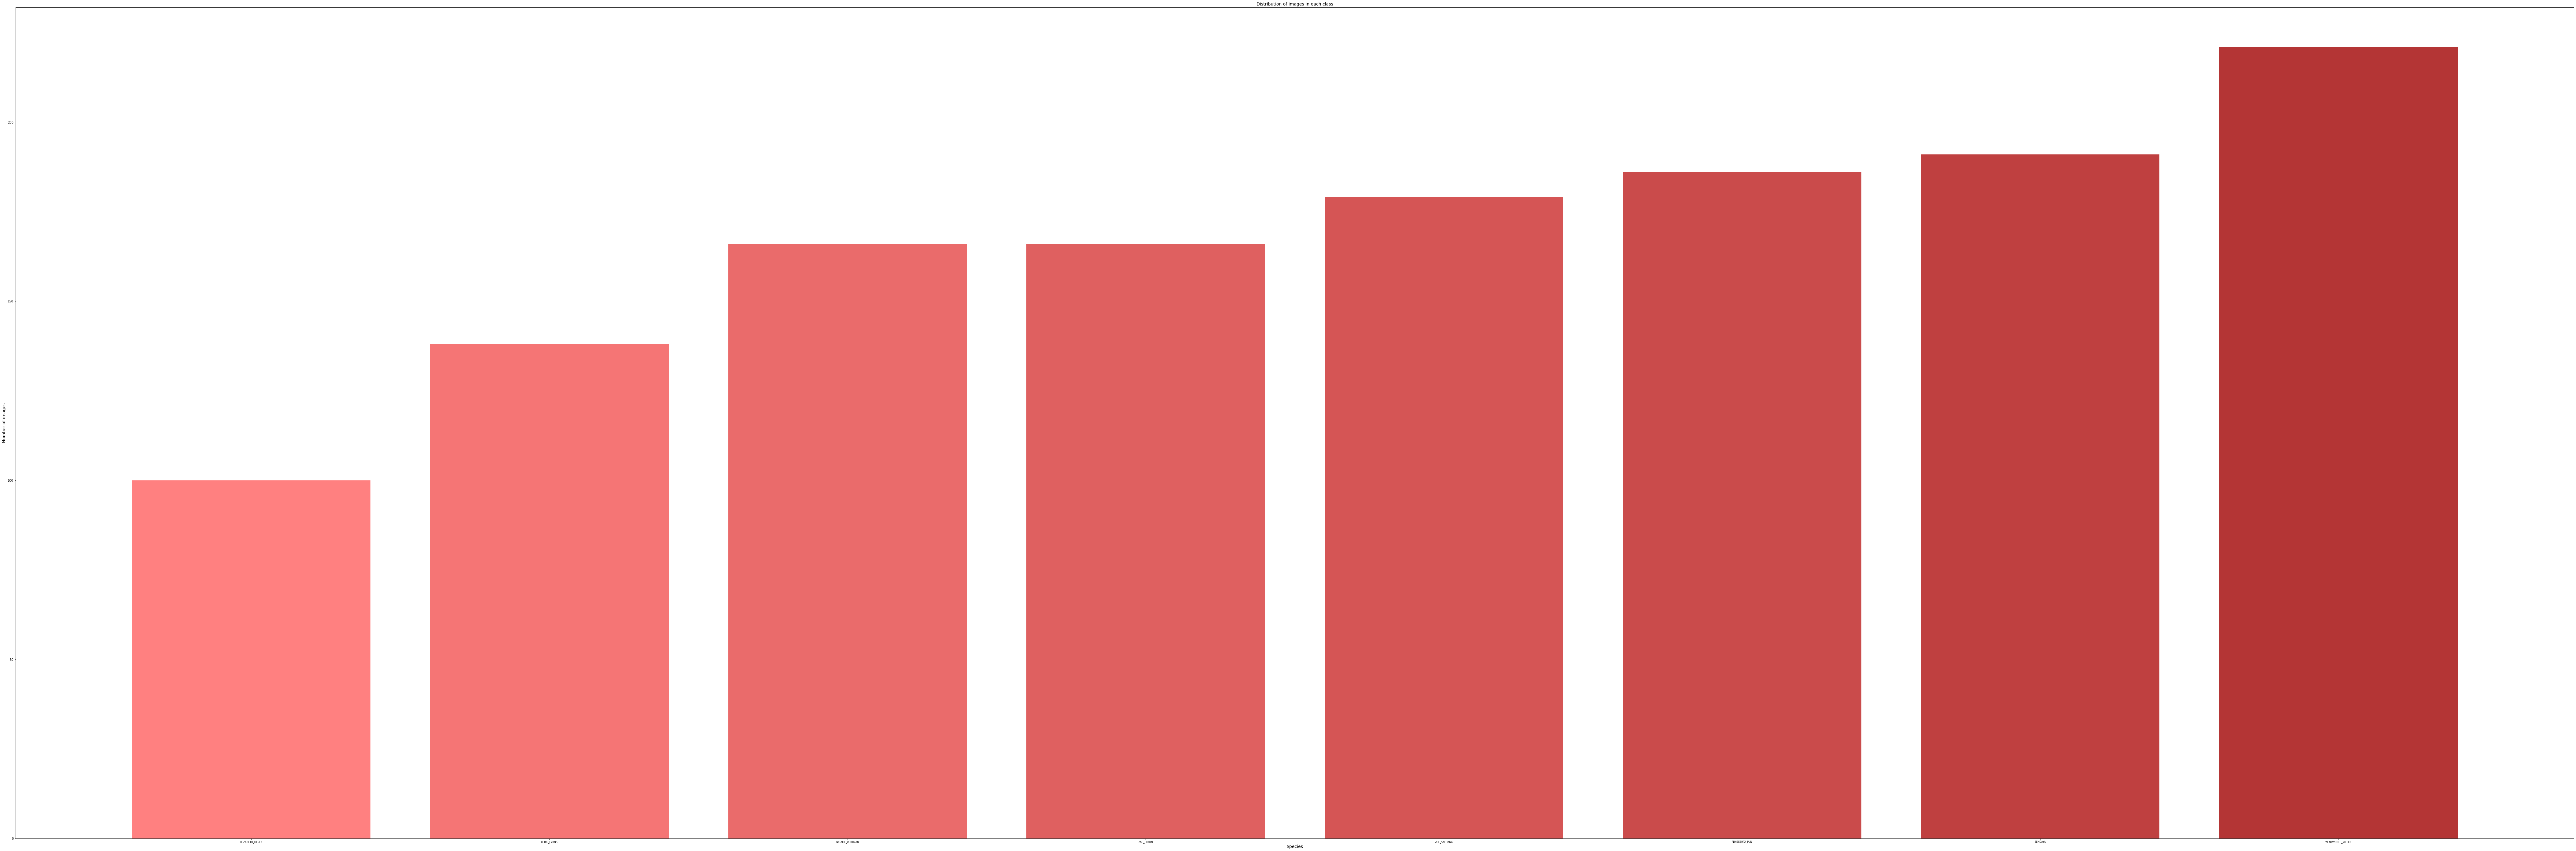

In [ ]:
import matplotlib as mp

values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(150,50))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

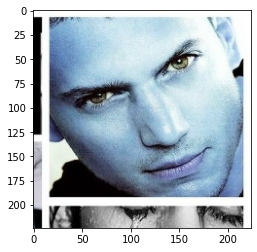

In [ ]:
plt.imshow(images[50])

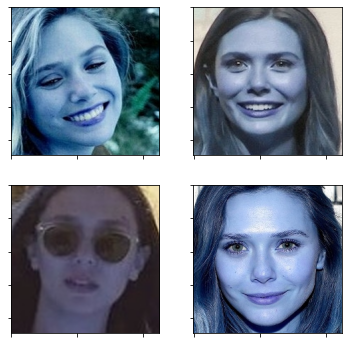

In [ ]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("ELIZABETH_OLSEN")

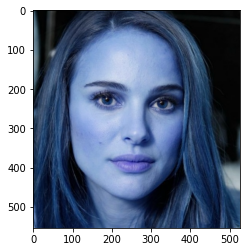

In [ ]:
sample_pic = "/content/drive/MyDrive/105_classes_pins_dataset/NATALIE_PORTMAN/Natalie_Portman12_3445.jpg"

# load image from file
image = cv2.imread(sample_pic)
plt.imshow(image)

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
os.chdir("/content")

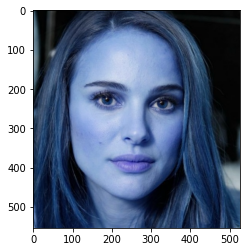

In [ ]:
sample_pic = '/content/drive/MyDrive/105_classes_pins_dataset/NATALIE_PORTMAN/Natalie_Portman12_3445.jpg'

# load image from file
image = cv2.imread(sample_pic)
plt.imshow(image)

In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3 MB 7.5 MB/s 


In [ ]:
from mtcnn.mtcnn import MTCNN

# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(image)
for face in faces:
  print(face)

{'box': [92, 77, 305, 388], 'confidence': 0.9999997615814209, 'keypoints': {'left_eye': (191, 230), 'right_eye': (334, 241), 'nose': (266, 319), 'mouth_left': (192, 381), 'mouth_right': (312, 389)}}


In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

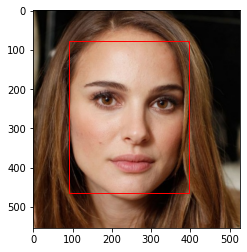

In [ ]:
highlight_faces('/content/drive/MyDrive/105_classes_pins_dataset/NATALIE_PORTMAN/Natalie_Portman12_3445.jpg', faces)

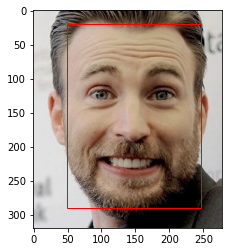

In [ ]:
image = plt.imread('/content/drive/MyDrive/105_classes_pins_dataset/CHRIS_EVANS/Chris_Evans36_1211.jpg')
faces = detector.detect_faces(image)

highlight_faces('/content/drive/MyDrive/105_classes_pins_dataset/CHRIS_EVANS/Chris_Evans36_1211.jpg', faces)

In [61]:
import PIL
from PIL import Image
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = cv2.imread(filename)
 
	# create the detector, using default weights
	detector = MTCNN()
 
	# detect faces in the image
	results = detector.detect_faces(pixels)
 
	# extract the bounding box from the first face
	try:
		x1, y1, width, height = results[0]['box']
		x2, y2 = x1 + width, y1 + height
	except:
		return None

	# extract the face
	face = pixels[y1:y2, x1:x2]

    # resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = np.asarray(image)
	#plt.imshow(face_array)
	return face_array

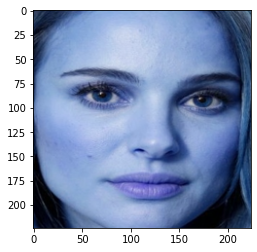

In [ ]:
# load the photo and extract the face
pixels = extract_face('/content/drive/MyDrive/105_classes_pins_dataset/NATALIE_PORTMAN/Natalie_Portman12_3445.jpg')

# plot the extracted face
plt.imshow(pixels)

# show the plot
plt.show()

In [ ]:
from keras_vggface.vggface import VGGFace
model = Sequential()
# create a vggface2 model
pretrained_model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
for layer in pretrained_model.layers:
    layer.trainable=False
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(8,activation="softmax"))
model.summary()

165453824/165439116 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_resnet50 (Functiona  (None, 8631)             41246071  
 l)                                                              
                                                                 
 flatten_5 (Flatten)         (None, 8631)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               4419584   
                                                                 
 dense_15 (Dense)            (None, 8)                 4104      
                                                                 
Total params: 45,669,759
Trainable params: 4,423,688
Non-trainable params: 41,246,071
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
img_height,img_width = 224,224
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split = 0.2,
    subset ="training",
    seed = 123,
    label_mode = "categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 1347 files belonging to 8 classes.
Using 1078 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split = 0.2,
    subset ="validation",
    seed = 123,
    label_mode = "categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 1347 files belonging to 8 classes.
Using 269 files for validation.


In [ ]:
type(model)

keras.engine.sequential.Sequential

In [ ]:
class_names = train_ds.class_names
print(class_names)

['ABHEESHTA_JAIN', 'CHRIS_EVANS', 'ELIZABETH_OLSEN', 'NATALIE_PORTMAN', 'WENTWORTH_MILLER', 'ZAC_EFRON', 'ZENDAYA', 'ZOE_SALDANA']


In [ ]:
epochs=5
history = model.fit(train_ds,validation_data = val_ds, epochs=epochs)

Epoch 1/5
34/34 [==============================] - 185s 5s/step - loss: 1.8881 - accuracy: 0.8813 - val_loss: 1.6022 - val_accuracy: 0.9888
Epoch 2/5
34/34 [==============================] - 166s 5s/step - loss: 1.2261 - accuracy: 0.9889 - val_loss: 0.8161 - val_accuracy: 0.9926
Epoch 3/5
34/34 [==============================] - 165s 5s/step - loss: 0.5362 - accuracy: 0.9926 - val_loss: 0.3223 - val_accuracy: 0.9851
Epoch 4/5
34/34 [==============================] - 178s 5s/step - loss: 0.2197 - accuracy: 0.9954 - val_loss: 0.1618 - val_accuracy: 0.9888
Epoch 5/5
34/34 [==============================] - 169s 5s/step - loss: 0.1156 - accuracy: 0.9963 - val_loss: 0.1047 - val_accuracy: 0.9888


In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [ ]:
print(len(pretrained_model.layers))

176


In [ ]:
# Remove last Softmax layer and get model upto last flatten layer #with outputs 2622 units 
vgg_face_descriptor= model

In [ ]:
type(model)

keras.engine.sequential.Sequential

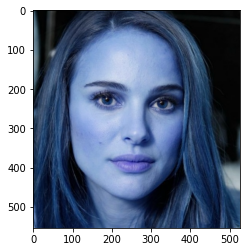

In [ ]:
from numpy import expand_dims
from keras_vggface.utils import preprocess_input

# load the photo and extract the face
pixels = extract_face('/content/drive/MyDrive/105_classes_pins_dataset/NATALIE_PORTMAN/Natalie_Portman12_3445.jpg')

# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)

# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)

In [ ]:
def get_embeddings(filenames):
    # extract faces
    faces = [extract_face(f) for f in filenames]
    # convert into an array of samples
    samples = np.asarray(faces, 'float32')
    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    # perform prediction
    yhat = model.predict(samples)
    #print(yhat[0])
    return yhat

In [65]:
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.3):
	# calculate distance between embeddings
	#score = cosine(known_embedding, candidate_embedding)
	score = np.linalg.norm(known_embedding-candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
		return 1
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
		return 0

In [66]:
from scipy.spatial.distance import cosine

# define filenames
filenames = ['/content/drive/MyDrive/105_classes_pins_dataset/NATALIE_PORTMAN/Natalie_Portman12_3445.jpg','/content/drive/MyDrive/105_classes_pins_dataset/CHRIS_EVANS/Chris_Evans36_1211.jpg',
             '/content/Person2.jpg','/content/drive/MyDrive/105_classes_pins_dataset/NATALIE_PORTMAN/Natalie_Portman12_3445.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define face
face_id = embeddings[0]
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
is_match(embeddings[0], embeddings[3])

>face is NOT a Match (1.344 > 0.300)
>face is NOT a Match (0.336 > 0.300)
>face is a Match (0.000 <= 0.300)


1